>Jakub Ryšavý
# INF265 - Week 5: Training an MLP on MNIST

In [57]:
# ## Google Colab code
# # download input files

# from google.colab import drive
# drive.mount('/content/drive')

# !cp /content/drive/MyDrive/VYSOKA/INF265-Deep_Learning/Week05_Training_MLP_MNIST/handwritten_digits_images.csv .
# !cp /content/drive/MyDrive/VYSOKA/INF265-Deep_Learning/Week05_Training_MLP_MNIST/handwritten_digits_labels.csv .
# # !cp -r /content/drive/MyDrive/VYSOKA/INF265-Deep_Learning/Week05_Training_MLP_MNIST/MNIST/ .
# print('Download of input files done!')

In [58]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms

from pathlib import Path
import matplotlib.pyplot as plt

### 2. Load data and store images

In [59]:
X = pd.read_csv("handwritten_digits_images.csv")
y = pd.read_csv("handwritten_digits_labels.csv")
print("shape of X:", X.shape, 
      "\nshape of y:", y.shape)

shape of X: (69999, 784) 
shape of y: (69999, 1)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [61]:
def store_images(data, labels, folder):
    path = Path('MNIST')/ folder
    for l in np.unique(labels):
        Path('MNIST/' + folder + '/' + str(l)).mkdir(parents=True, exist_ok=True)
    for i, label in zip(range(len(data)), labels.values):
        label = label[0]
        im = data.iloc[i]
        im = np.array(im, dtype='uint8')
        im = im.reshape((28, 28))
        img = Image.fromarray(im)
        name = path/ str(label)/ str(str(i) + '.jpg')
        img.save(name)
    print(f"Storing {folder} images finished! :-)")

store_images(X_train, y_train, 'train')
store_images(X_val, y_val, 'val')
store_images(X_test, y_test, 'test')

Storing train images finished! :-)
Storing val images finished! :-)
Storing test images finished! :-)


## 3. Preprocessing
Write a data preprocessor using the classes available in ’torchvision.transforms’
that first converts images to grayscale, then pads two black pixels around
images (output dimensions should become 32×32) and finally converts images to tensors. **Hint**: You can use the class ’torchvision.transforms.Compose()’
to chain a list of transforms.

In [62]:
preprocessor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(2),
    transforms.ToTensor(),
]) 

## 4. Create datasets
Use the ’torchvision.datasets.ImageFolder()’ class to create the MNIST train/validation/test datasets, given the paths obtained from the folders
hierarchy in Question 2 and the data preprocessor created in Question 3.

In [63]:
import torchvision.datasets
train_dataset = torchvision.datasets.ImageFolder(root='MNIST/train', transform=preprocessor)
val_dataset = torchvision.datasets.ImageFolder(root='MNIST/val', transform=preprocessor)
test_dataset = torchvision.datasets.ImageFolder(root='MNIST/test', transform=preprocessor)

train_dataset, val_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 41999
     Root location: MNIST/train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 14000
     Root location: MNIST/val
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 14000
     Root location: MNIST/test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
            ))


## 5. Create DataLoader
Use the ’torch.utils.data.DataLoader()’ class to instantiate generators for
the MNIST datasets generated in Question 4. Make sure that the train
generator is set to shuffle data.

In [64]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

train_loader, valid_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fe4a9a03d30>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe4a9a03e10>)

## 6. Questions
* In which context do we need data generators?
    * Data loader is usually useful when dealing with large data.
    * Thanks to them, whole data does not have to be loaded to the memory.
    * In PyTorch, the input of a model have to be a *tensor* type. This is also done by data loaders.
* How do data generators typically work?
    1. It takes the data in amount of one batch,
    2. it shuffles the batch (if not ``shuffle=False``),
    3. it returns the batch.




## 7. Simple MLP
Write a simple MLP using the classes available in ’torch.nn’. Hint: You
can use the class ’torch.nn.Sequential()’ to stack successive layers.

In [65]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(32*32, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        # convert tensor (128, 1, 32, 32) ->(128, 1*32*32) 
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

model = MLP()
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


## 9. Training loop
Adapt the codes from the aforementioned links to implement your custom training loop. Each iteration of this loop should process your whole training set once (this is called an epoch). During each epoch, you will perform forward and backward passes with the MLP created in Question 7 on the batches returned by your train generator. Every processed batch will be followed by an update of the neural network’s parameters. You can for instance use the categorical cross-entropy loss implemented in the class ’pytorch.nn.CrossEntropyLoss()’.

In [66]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def loss_batch(model, loss_func, xb, yb, opt=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    acc = accuracy(preds, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb), acc

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, test_dl):
    mean_train_losses = []
    mean_train_acc = []
    mean_val_losses = []
    val_acc_list = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        running_acc = 0
        ls = 0
        for xb, yb in train_dl:
            loss, l, acc = loss_batch(model, loss_func, xb, yb, opt)
            running_loss += loss * l
            running_acc += acc * l
            ls += l
        mean_train_losses.append(running_loss/ls)
        mean_train_acc.append(running_acc/ls)

        model.eval()
        with torch.no_grad():
            losses, nums, accuracies = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(accuracies, nums)) / np.sum(nums)
        mean_val_losses.append(val_loss)
        val_acc_list.append(val_acc)
        
        print('epoch ', epoch, ':\n\t', val_loss, '; ', val_acc*100, '%', sep='')

    model.eval()
    with torch.no_grad():
        losses, nums, accuracies = zip(
            *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
        )
    test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_acc = np.sum(np.multiply(accuracies, nums)) / np.sum(nums)
    
    print('\nTest loss: ', test_loss,
          '\nTest accuracy: ', test_acc*100, '%\n', sep='')
    return mean_train_losses, mean_train_acc, mean_val_losses, val_acc_list, test_loss, test_acc

epochs = 30
lr = 0.1
opt = torch.optim.SGD(model.parameters(), lr=lr)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = fit(epochs, model, nn.CrossEntropyLoss(), opt, train_loader, valid_loader, test_loader)
print(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)

epoch 0:
	0.37411452402387346; 89.22142856461662%
epoch 1:
	0.342711428301675; 89.7928571496691%
epoch 2:
	0.27114236535344804; 92.22857142175947%
epoch 3:
	0.3253245223249708; 89.78571427890233%
epoch 4:
	0.22596091273852756; 93.59999999318805%
epoch 5:
	0.2235396203654153; 93.60000000681195%
epoch 6:
	0.20133164616993496; 94.4071428503309%
epoch 7:
	0.18406327361719949; 94.71428570747375%
epoch 8:
	0.17352694640840802; 95.02142856461661%
epoch 9:
	0.16153881112166812; 95.44285714966911%
epoch 10:
	0.16833709641865321; 95.26428572109768%
epoch 11:
	0.14889404612779616; 95.75714286395481%
epoch 12:
	0.14404800524881908; 95.80000000681196%
epoch 13:
	0.14845605818714414; 95.72857143538339%
epoch 14:
	0.13155095772232328; 96.23571429252624%
epoch 15:
	0.12898410544225147; 96.3285714353834%
epoch 16:
	0.12382167369127274; 96.52142857824053%
epoch 17:
	0.1255082478949002; 96.3928571496691%
epoch 18:
	0.11638196711029325; 96.7928571496691%
epoch 19:
	0.13781218822513308; 95.95000000681196%


## 13. Hyperparameters Tuning
Find a configuration of hyperparameters such that your model reaches at
least 90% accuracy on the test set. Indicate in your report the specifics of
your architecture and the chosen hyperparameters.
* Any specific tuning is needed. The models performs well just with following setup.
    * optimizer: *SGD*
    * learning_rate = 0.1
    * number_of_epochs = 25
    * loss function: *CrossEntropyLoss*

## 14. Plot Results
Produce plots for the train/validation accuracy and loss curves. Make
sure to properly title your figures, legend your plots and label your axis.

### Loss

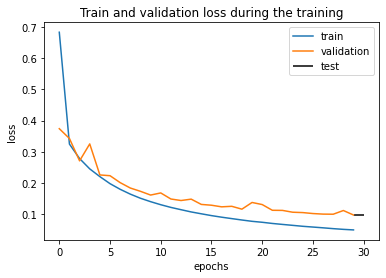

In [67]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.hlines(test_loss, len(train_loss)-1, len(train_loss), label='test')
plt.title('Train and validation loss during the training')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

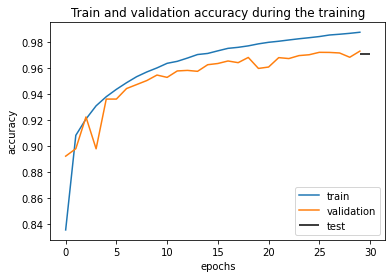

In [68]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.hlines(test_acc, len(train_acc)-1, len(train_acc), label='test')
plt.title('Train and validation accuracy during the training')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

**Thank you** for interesting assigment even though I firstly struggled at the beginning (data loading).


>Jakub Ryšavý



